In [1]:
import glob
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras import models
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cleverhans
from cleverhans.tf2.attacks import fast_gradient_method

In [2]:
def read_many(path):
    """
    Read all imagens in directory.
    
    Parameters
    ----------
    path: str
        Dataset path of a class (COVID or NON-COVID).
    
    Returns
    -------
    out : [ndarray]
        List of images.
    """
    # Get the path of all images
    list_imgs = list(glob.glob(path))
    out = []
    
    # Load all images of the given paths
    for i in range(len(list_imgs)):
        # Read the image in shape of (244, 244, 3)
        try:
            img = image.load_img(list_imgs[i], target_size=(224, 224, 3))
            x = image.img_to_array(img)
            out.append(x)
        # Print error
        except ValueError:
            print('Error reading the following image:', list_imgs[i])
    
    # Return the loaded images
    return out


def load_dir(paths):
    """
    Read images of COVID and NON-COVID cases.
    
    Parameters
    ----------
    paths: [str]
        Original and augmented dataset paths.
    
    Returns
    -------
    X : [ndarray]
        List of images.
    Y : [str]
        Labels of the images (i.e., 0 - NON-COVID; 1 - COVID).
    """
    # Arrays of images of COVID and NON-COVID cases
    covid = []
    non_covid = []
    
    # Read images
    for path in paths:
        # Read images of covid cases
        covid.extend(read_many('{}/COVID/*'.format(path)))
        # Read images of non-covid cases
        non_covid.extend(read_many('{}/NON_COVID/*'.format(path)))
    
    # Set COVID classes
    y_covid = np.asarray([1] * len(covid))
    y_non_covid = np.asarray([0] * len(non_covid))
    
    # Merge the read images
    X = np.concatenate([np.array(covid), np.array(non_covid)]) / 255
    Y = np.concatenate([np.array(y_covid), np.array(y_non_covid)])
    lb = LabelBinarizer()
    Y=lb.fit_transform(Y)
    
    assert len(X) == len(Y), 'The number of images and the number of classes are different!'
    print('Images read:', len(X))
    
    # Return the read images and their labels
    return (X, Y)

In [15]:
def load_models(path):
    models_name=list(glob.glob(path+"*"))
    models={}
    
    for model_name in models_name:
        #mprint(models_name)
        file=model_name.split("/")[-1]
        name=file.split(".")[0]
        models[name]=tf.keras.models.load_model(model_name)
        
    return models
    

In [67]:
from cleverhans.tf2.utils import optimize_linear, compute_gradient


def fast_gradient_method_bla(
    model_fn,
    x,
    eps,
    norm,
    loss_fn=None,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    sanity_checks=False,
):
    """
    Tensorflow 2.0 implementation of the Fast Gradient Method.
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf, 1 or 2.
    :param loss_fn: (optional) callable. Loss function that takes (labels, logits) as arguments and returns loss.
                    default function is 'tf.nn.sparse_softmax_cross_entropy_with_logits'
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
              target label. Otherwise, only provide this parameter if you'd like to use true
              labels when crafting adversarial samples. Otherwise, model predictions are used
              as labels to avoid the "label leaking" effect (explained in this paper:
              https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
              Untargeted, the default, will try to make the label incorrect.
              Targeted will instead try to move in the direction of being more like y.
    :param sanity_checks: bool, if True, include asserts (Turn them off to use less runtime /
              memory or for unit tests that intentionally pass strange input)
    :return: a tensor for the adversarial example
    """
    if norm not in [np.inf, 1, 2]:
        raise ValueError("Norm order must be either np.inf, 1, or 2.")

    if loss_fn is None:
        loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits

    asserts = []

    # If a data range was specified, check that the input was in that range
    if clip_min is not None:
        asserts.append(tf.math.greater_equal(x, clip_min))

    if clip_max is not None:
        asserts.append(tf.math.less_equal(x, clip_max))

    # cast to tensor if provided as numpy array
    x = tf.cast(x, tf.float32)
    print ("x sum", np.sum(x))

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        y = tf.argmax(model_fn(x), 1)
    print("y=",y,type(y))
    grad = compute_gradient(model_fn, loss_fn, x, y, targeted)
    print ("gradsum=",np.sum(grad))

    optimal_perturbation = optimize_linear(grad, eps, norm)
    # Add perturbation to original example to obtain adversarial example
    adv_x = x + optimal_perturbation
    print ("perturbation_sum=",np.sum(optimal_perturbation))
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)

    if sanity_checks:
        assert np.all(asserts)
    return adv_x

In [31]:
TestX, TestY = load_dir(['Dataset/Test'])

Images read: 800


In [5]:
models=load_models("modelos/")

In [6]:
models.keys()
models['None']

In [7]:
preds={}
for name in models.keys():
    print (name)
    preds[name]=models[name].predict(TestX)

None


In [93]:
a = tf.constant([TestX[0]])   



In [82]:

#lb = LabelBinarizer()
#Y_max=np.asarray([np.max(preds["None"])])
Y_max=np.max(preds["None"])
Y_max=tf.convert_to_tensor([Y_max])

logits_model = tf.keras.Model(models["None"].input,models["None"].layers[-1].output)
Y_max

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.99999976], dtype=float32)>

In [95]:
adv_sample = fast_gradient_method_bla(logits_model, a, 0.7, 1, targeted=True,sanity_checks=True)
#fast_gradient_method

x sum 77719.3
y= tf.Tensor([0], shape=(1,), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'>
gradsum= 0.0
perturbation_sum= 0.0


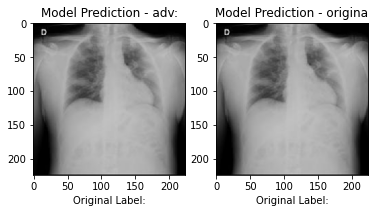

In [96]:
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.imshow(adv_sample[0], cmap='gray')
plt.title("Model Prediction - adv:")
plt.xlabel("Original Label:")
plt.subplot(122)
plt.imshow(a[0], cmap='gray')
plt.title("Model Prediction - origina")
plt.xlabel("Original Label:")
plt.show()

In [97]:
np.sum((adv_sample[0]- a[0])**2)

0.0

In [120]:
lb = LabelBinarizer()
metrics_names={"balanced accuracy": [],"f1-score":[],"precision":[],"recall":[]}
order=["None","Noise","Rotation","Sharpness","Contrast"]
data=[]
for pred_name in order:
    data.append(preds[pred_name])
    Y=lb.fit_transform(preds[pred_name]>0.5)
    print (pred_name)
    metrics_names["balanced accuracy"].append(metrics.balanced_accuracy_score(TestY, Y))
    metrics_names["f1-score"].append(metrics.f1_score(TestY, Y))
    metrics_names["precision"].append(metrics.precision_score(TestY, Y))
    metrics_names["recall"].append(metrics.recall_score(TestY, Y))
    
    print(metrics.classification_report(TestY, Y))
    print ('\n'*10)


df2 = pd.DataFrame.from_dict(metrics_names, orient='index',columns=order)


None
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       600
           1       0.81      0.92      0.86       200

    accuracy                           0.93       800
   macro avg       0.89      0.92      0.90       800
weighted avg       0.93      0.93      0.93       800












Noise
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       600
           1       0.42      0.98      0.59       200

    accuracy                           0.65       800
   macro avg       0.70      0.76      0.64       800
weighted avg       0.85      0.65      0.67       800












Rotation
              precision    recall  f1-score   support

           0       0.89      0.67      0.76       600
           1       0.43      0.76      0.55       200

    accuracy                           0.69       800
   macro avg       0.66      0.71      0.66       800
weighted avg       0.78      0.6

In [85]:
df2

,None,Noise,Rotation,Sharpness,Contrast
balanced accuracy,0.921667,0.762500,0.710833,0.896667,0.928333
f1-score,0.859155,0.585438,0.548094,0.848485,0.902564
precision,0.809735,0.416490,0.430199,0.857143,0.926316
recall,0.915000,0.985000,0.755000,0.840000,0.880000


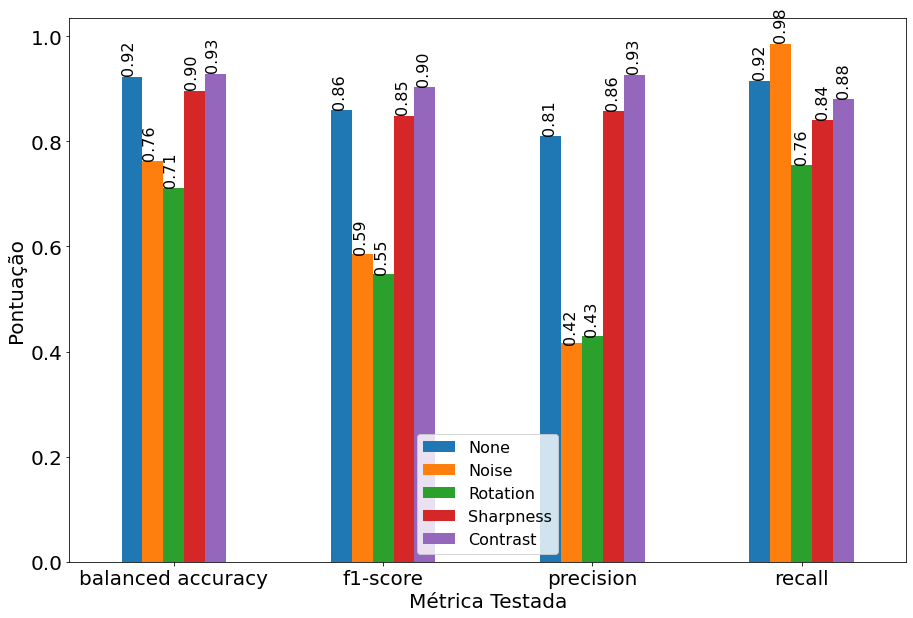

In [102]:

ax = df2.plot.bar(rot=0,figsize=(15, 10),fontsize=20)
for p in ax.patches:
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010),fontsize=16,rotation=90)
    
ax.set_ylabel("Pontuação",fontsize=20)
ax.set_xlabel("Métrica Testada",fontsize=20)
ax.legend(loc=0,fontsize=16)  
#plt.tick_params( labelsize=17)



    

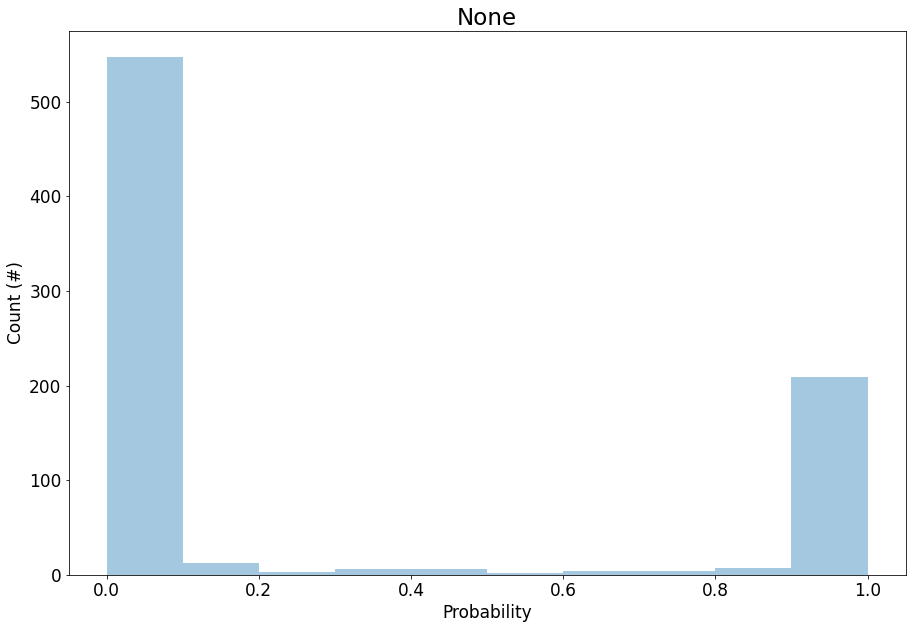

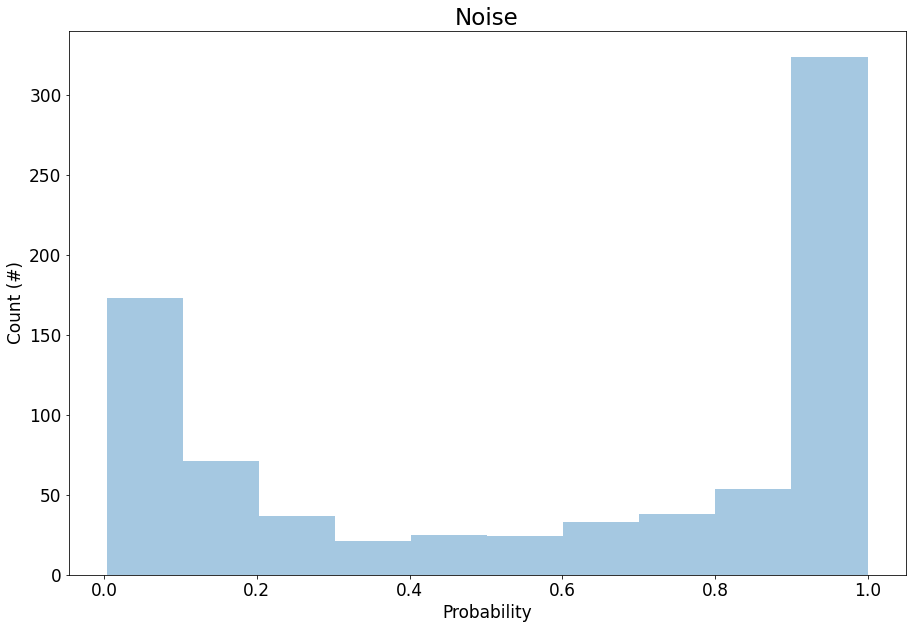

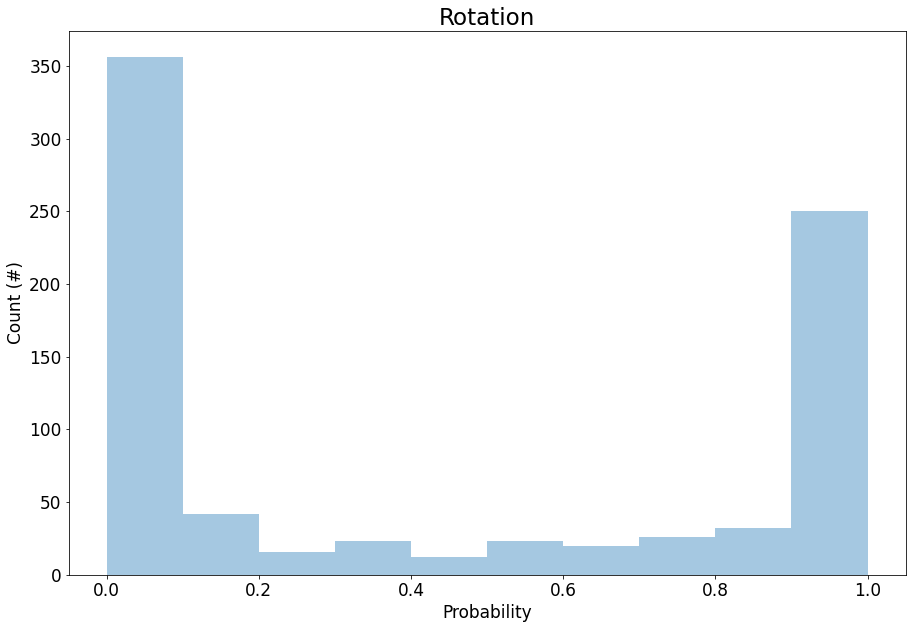

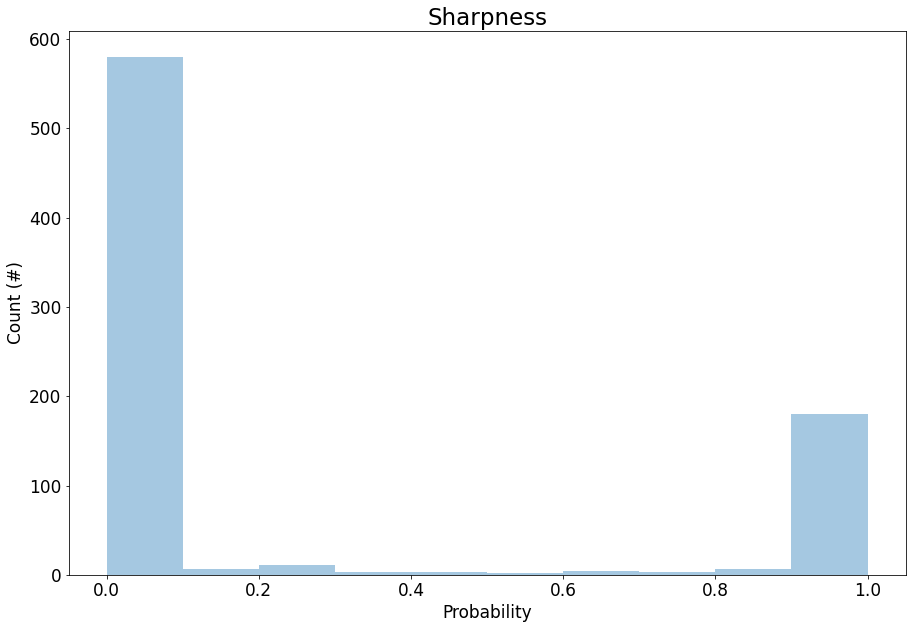

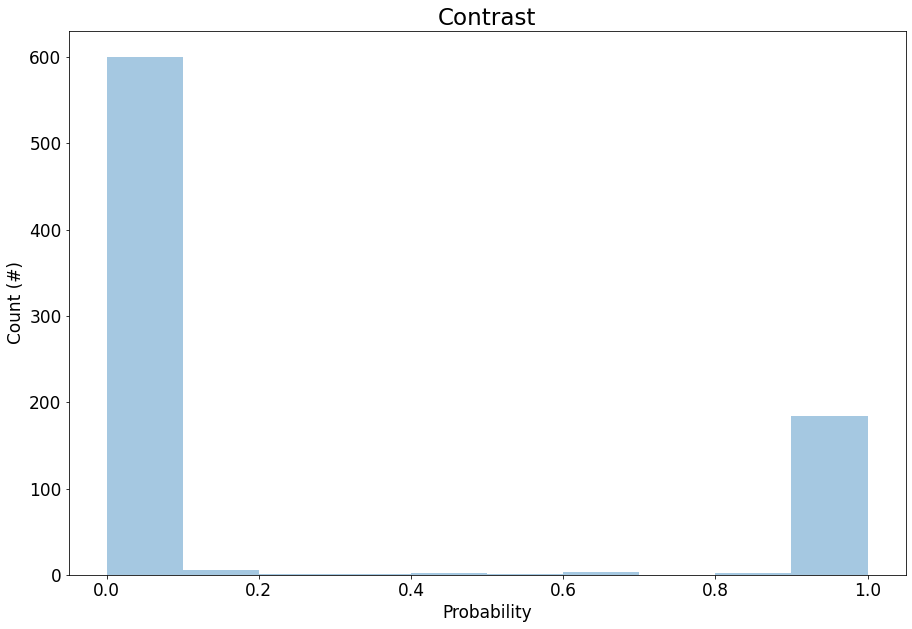

In [137]:

for i in order:
    plt.figure(figsize=(15,10))
    sns.distplot(preds[i],kde=False,bins=10)
    plt.title(i,fontsize=23)
    plt.ylabel("Count (#)",fontsize=17)
    plt.xlabel ("Probability",fontsize=17)
    plt.tick_params( labelsize=17)
    plt.show()
    
#sns.distplot(preds["None"],kde=False,bins=10)


In [ ]:
lb = LabelBinarizer()
labels2 = lb.fit_transform(labels)
labels2 = to_categorical(labels2)
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
